In [1]:
import os
import copy
import glob

import numpy as np
import astropy.units as u
import astropy.constants as c
import matplotlib.pyplot as plt

import hera_pspec as hp
from hera_pspec.data import DATA_PATH
from pyuvdata import UVData
from hera_cal import redcal

In [2]:
# Locate data
dfiles = sorted(glob.glob("/lustre/aoc/projects/hera/H1C_IDR2/IDR2_1/2458111/zen.2458111.30???.xx.HH.uvOCRSD"))

In [3]:
%%time
# Initialize UVData object to read and contain MIRIAD information
uvd = UVData()
uvd.read_miriad(dfiles, ant_str='cross')

# Apply flags
uvd.data_array *= np.logical_not(uvd.flag_array)

# Intialize a cosmology and a beam
cosmo = hp.conversions.Cosmo_Conversions()
beamfile = os.path.join(DATA_PATH, 'NF_HERA_Beams.beamfits')
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)

# Convert to cosmological units (mK)
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol="xx")
uvd.data_array *= Jy_to_mK[None, None, :, None]

# Shift data and load datasets
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)

ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

CPU times: user 15.9 s, sys: 3.62 s, total: 19.5 s
Wall time: 19.6 s


In [4]:
%%time
# Phase data (What does this do?)
ds.rephase_to_dset(0)

CPU times: user 4.13 s, sys: 27 ms, total: 4.15 s
Wall time: 4.15 s


In [5]:
%%time
# Categorize baselines into physical separation length
BIN_WIDTH = 0.3
NORM_BINS = np.arange(0.0, 10000.0, BIN_WIDTH)

antpos = {ant: pos for ant, pos in zip(uvd.get_ENU_antpos()[1], uvd.get_ENU_antpos()[0])}

antpairs = uvd.get_antpairs()
xants1, xants2 = hp.utils.calc_reds(uvd1, uvd2)[3:]
xants = np.unique(xants1 + xants2)

reds = {}
for antpair in antpairs:
    ant0, ant1 = antpair
    if (ant0 in xants) or (ant1 in xants) or (ant0 >= ant1):
        continue
    norm = np.linalg.norm(antpos[ant0] - antpos[ant1])
    norm = np.round(np.digitize(norm, NORM_BINS) * BIN_WIDTH, 1)

    if norm in reds:
        reds[norm].append(antpair)
    else:
        reds[norm] = [antpair]
norms = sorted(reds.keys())

CPU times: user 1.36 s, sys: 8 ms, total: 1.37 s
Wall time: 1.37 s


In [7]:
%%time
# Initialize UVPspec objects for each baseline bin
uvps = [] 
for norm in norms:
    uvp = ds.pspec(
        reds[norm],
        reds[norm],
        (0, 1),
        pols=("xx", "xx"),
        spw_ranges=[(580,680)],
        taper="blackman-harris")
    uvps.append(uvp)


Setting spectral range: (580, 680)

Using polarization pair: ('XX', 'XX')

(bl1, bl2) pair: ((1, 12), (1, 12))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((1, 13), (1, 13))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((11, 12), (11, 12))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((11, 23), (11, 23))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((11, 24), (11, 24))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 13), (12, 13))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 24), (12, 24))
pol: (-5, -5)
  


(bl1, bl2) pair: ((67, 84), (67, 84))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((68, 69), (68, 69))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((68, 84), (68, 84))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((68, 85), (68, 85))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((69, 70), (69, 70))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((69, 85), (69, 85))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((69, 86), (69, 86))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


(bl1, bl2) pair: ((27, 39), (27, 39))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((27, 55), (27, 55))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 52), (36, 52))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 66), (36, 66))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 53), (37, 53))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 67), (37, 67))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 51), (38, 51))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


(bl1, bl2) pair: ((11, 38), (11, 38))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 14), (12, 14))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 37), (12, 37))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 39), (12, 39))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((13, 38), (13, 38))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((13, 40), (13, 40))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((14, 39), (14, 39))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


(bl1, bl2) pair: ((86, 121), (86, 121))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((86, 123), (86, 123))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((87, 122), (87, 122))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((87, 124), (87, 124))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((88, 123), (88, 123))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((120, 122), (120, 122))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((121, 123), (121, 123))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and mul


(bl1, bl2) pair: ((37, 65), (37, 65))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 69), (37, 69))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 83), (37, 83))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 84), (37, 84))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 55), (38, 55))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 66), (38, 66))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 70), (38, 70))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


(bl1, bl2) pair: ((83, 121), (83, 121))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 138), (83, 138))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 139), (83, 139))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((84, 122), (84, 122))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((84, 139), (84, 139))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((84, 140), (84, 140))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((85, 123), (85, 123))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multipl


(bl1, bl2) pair: ((65, 68), (65, 68))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((66, 69), (66, 69))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((66, 120), (66, 120))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((67, 70), (67, 70))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((67, 121), (67, 121))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((68, 71), (68, 71))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((68, 122), (68, 122))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying sca


(bl1, bl2) pair: ((52, 87), (52, 87))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((52, 120), (52, 120))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((53, 82), (53, 82))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((53, 88), (53, 88))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((53, 121), (53, 121))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((54, 83), (54, 83))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((54, 122), (54, 122))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying sca


(bl1, bl2) pair: ((36, 54), (36, 54))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 85), (36, 85))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 55), (37, 55))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 86), (37, 86))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 82), (38, 82))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 87), (38, 87))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((39, 83), (39, 83))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


(bl1, bl2) pair: ((86, 139), (86, 139))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((87, 140), (87, 140))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((88, 141), (88, 141))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((120, 143), (120, 143))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((121, 137), (121, 137))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((122, 138), (122, 138))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((123, 139), (123, 139))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and


(bl1, bl2) pair: ((11, 55), (11, 55))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((11, 83), (11, 83))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((11, 84), (11, 84))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 84), (12, 84))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 85), (12, 85))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((13, 85), (13, 85))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((13, 86), (13, 86))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...


(bl1, bl2) pair: ((82, 141), (82, 141))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 123), (83, 123))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((83, 142), (83, 142))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((84, 124), (84, 124))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((84, 143), (84, 143))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((85, 137), (85, 137))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((86, 138), (86, 138))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multipl


(bl1, bl2) pair: ((55, 141), (55, 141))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((65, 86), (65, 86))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((65, 140), (65, 140))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((66, 87), (66, 87))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((66, 141), (66, 141))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((67, 88), (67, 88))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((67, 142), (67, 142))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying s


(bl1, bl2) pair: ((39, 141), (39, 141))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((40, 82), (40, 82))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((40, 142), (40, 142))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((41, 83), (41, 83))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((41, 143), (41, 143))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((65, 122), (65, 122))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((66, 123), (66, 123))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying


(bl1, bl2) pair: ((11, 87), (11, 87))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((12, 88), (12, 88))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((13, 82), (13, 82))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((14, 83), (14, 83))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((23, 121), (23, 121))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 122), (24, 122))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((25, 123), (25, 123))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying sca


(bl1, bl2) pair: ((23, 88), (23, 88))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((23, 138), (23, 138))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((23, 139), (23, 139))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 139), (24, 139))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((24, 140), (24, 140))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((25, 140), (25, 140))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((25, 141), (25, 141))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplyi


(bl1, bl2) pair: ((27, 140), (27, 140))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((36, 142), (36, 142))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 143), (37, 143))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((39, 137), (39, 137))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((40, 138), (40, 138))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((41, 139), (41, 139))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((65, 88), (65, 88))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplyi


(bl1, bl2) pair: ((27, 138), (27, 138))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (580, 680)

Using polarization pair: ('XX', 'XX')

(bl1, bl2) pair: ((1, 140), (1, 140))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((1, 141), (1, 141))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (580, 680)

Using polarization pair: ('XX', 'XX')

(bl1, bl2) pair: ((1, 139), (1, 139))
pol: (-5, -5)
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((1, 142), (1, 142))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((41, 137), (41, 137))
pol: (-5, -5)
  Building q_hat...
  Normalizing power spectr

In [8]:
%%time
# Average each UVPspec object in time and baseline bin and fold into wedge
for uvp, norm in zip(uvps, norms):
    blpairs = [[(bl, bl) for bl in reds[norm]]]
    uvp.average_spectra(blpair_groups=blpairs, time_avg=True)
    uvp.fold_spectra()
    uvp.data_array[0] = uvp.data_array[0].reshape(
        (len(uvp.freq_array)))[np.nonzero(uvp.data_array[0].reshape((len(uvp.freq_array))))]

CPU times: user 353 ms, sys: 8 ms, total: 361 ms
Wall time: 358 ms


In [9]:
# Load data from UVPspec objects into an array
wedge = np.array([uvp.data_array[0] for uvp in uvps])

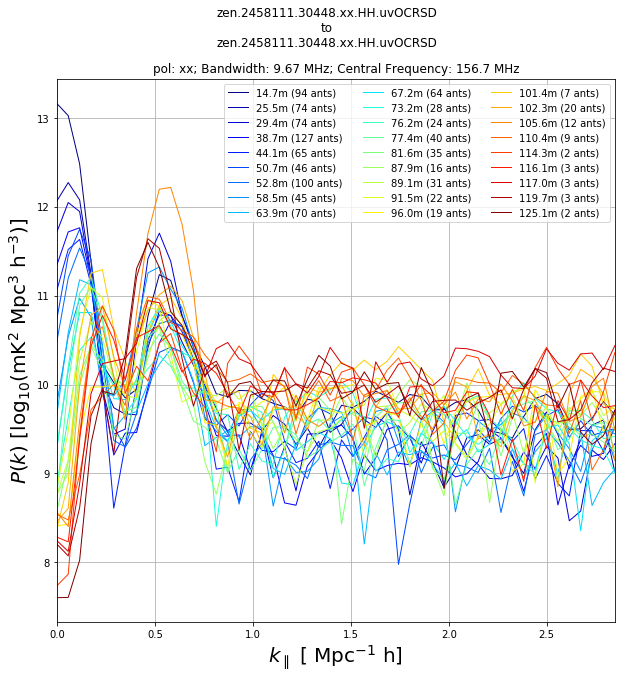

In [10]:
"""Plotting"""
def get_cmap(n, name='jet'):
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(len(uvps))

# Make a copy of a uvp object to get freq_array and kparas
UVP = copy.deepcopy(uvps[0])

# Find bandwidth and central frequency in MHz for naming
BAND_START = (UVP.freq_array[0] * u.Hz).to(u.MHz)
BAND_STOP = (UVP.freq_array[-1] * u.Hz).to(u.MHz)
BANDWIDTH = (BAND_STOP - BAND_START)
CENTRAL_FREQ = ((BANDWIDTH / UVP.Nfreqs) + BAND_START)

# Generate x-values to plot against
kparas = (UVP.get_kparas(0)/u.Mpc).insert(0, 0)

Tsys = 400
plt.figure(figsize=(10, 10))
for i, (uvp, norm, pspec) in enumerate(zip(uvps, norms, wedge)):
    plt.plot(
        kparas,
        np.log10(np.abs(pspec)),
        c=cmap(i),
        ls='-',
        lw=1,
        label='{norm}m ({ants} ants)'.format(norm=norm, ants=len(reds[norm])))

#     noise = uvp.generate_noise_spectra(0, 'xx', Tsys)
#     noise = noise[noise.keys()[0]]
#     noise = np.insert(noise, 0, noise[0, 0], axis=1)
#     noise = noise.reshape(len(kparas))
#     noise = np.log10(noise)
#     plt.plot(
#         kparas,
#         noise,
#         c=cmap(i),
#         ls='--',
#         lw=1,
#         label='{norm}m {Tsys}K'.format(norm=norm, Tsys=Tsys))
    
    
plt.legend(loc='upper right', ncol=3)

# x-axis
plt.xlim((0, UVP.get_kparas(0)[-1]))
plt.xlabel(r"$k_{\parallel}\ [\rm\ Mpc^{-1}\ h]$", size=20)

# y-axis
# plt.ylim((0, 20))
plt.ylabel(r"$P(k)\ \rm [\log_{10}({mK^2\ Mpc^3\ h^{-3}})]$", size=20)

# Titles
plt.title("pol: xx; Bandwidth: {BW}; Central Frequency: {CF}".format(
    BW=np.round(BANDWIDTH, 2),
    CF=np.round(CENTRAL_FREQ, 1)))
plt.suptitle(os.path.basename(dfiles[0]) + "\nto\n" + os.path.basename(dfiles[-1]))

# Save and show the plot with a grid
plt.grid()
plt.savefig("xx.{BW}_{CF}.{JD0}_{JDf}{DFext}.pdf".format(
    BW=np.round(BANDWIDTH.value, 2),
    CF=np.round(CENTRAL_FREQ.value, 1),
    JD0=dfiles[0].split(".")[2],
    JDf=dfiles[-1].split(".")[2],
    DFext=os.path.splitext(dfiles[0])[1]))
plt.show()

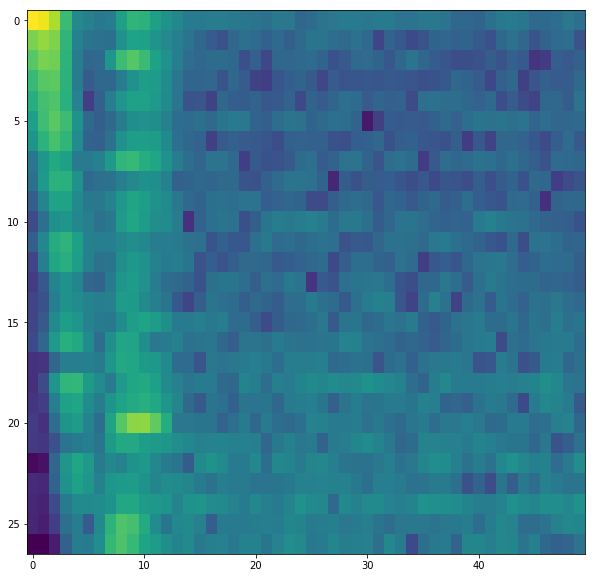

<Figure size 432x288 with 0 Axes>

In [21]:
plt.figure(figsize=(10, 10))
plt.imshow(np.log10(np.abs(wedge)), interpolation="nearest", aspect="auto")

# plt.tick_params(axis='both', direction='inout')

# plt.xticks([])
# plt.xlabel(str(norms[i]) + " m", rotation=45, ha="center")

# horizon = ((norms[i]*u.m / c.c).to(u.ns)).value
# plt.axhline(y=horizon, color="w", ls=":")
# plt.axhline(y=-horizon, color="w", ls=":")

# plt.ylim((uvp.get_dlys(0)[0]*1e9 / 2., uvp.get_dlys(0)[-1]*1e9 / 2.))
    
# plt.text(0.07, 0.5, r"$\tau$ [ns]", ha="center", rotation="vertical", size=20)
# plt.text(0.5, 0.04, "Redundant Baseline Group", ha="center", size=20)
# plt.subplots_adjust(wspace=0, hspace=0)
# cbar_ax = fig.add_axes([0.9125, 0.25, 0.025, 0.5])
# cbar = fig.colorbar(im, cax=cbar_ax)
# cbar.set_label(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=20, ha='center')
plt.show()
plt.clf()